Title: Linear Filters
Author: Thomas M. Breuel

In [2]:

from scipy.ndimage import filters
def ims(image,**kw):
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    subplots(1,1,figsize=(size,size))
    gray(); imshow(image,origin='lower',**kw)
def imp(image,**kw):
    subplots(1,1,figsize=(6,6))
    gray(); imshow(image,origin='lower',interpolation='nearest',**kw)
def imrow(*args,**kw):
    gray()
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    n = len(args)
    subplots(1,n,figsize=(n*size,size))
    for i,im in enumerate(args):
        subplot(1,n,i+1); imshow(im,origin='lower',**kw)
def rescale(image):
    return (image-amin(image))/max(1e-4,amax(image)-amin(image))

# Linear Filters

(Linear Filters)

One of the most important concepts in image processing is that of a _linear filter_.
Almost every signal and image processing application uses a linear filter somewhere.

We will look at...

- what linear filters do to images
- statistical justifications for using linear filters
- mathematical properties of linear filters
- transform methods related to linear filters

## Test Images

Here are two test images.  The first is a natural image. 
The second is an image with lines at various orientations and dots of different sizes.
Observing what happens to its elements helps you understand the action of various filters.

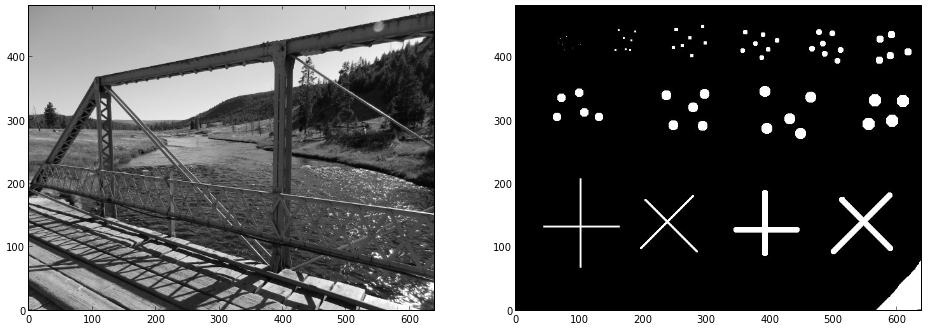

In [3]:
# test image examples
image = mean(imread("bridge.jpg")/255.0,axis=2)[::-1]
test = mean(imread("testimage.jpg")/255.0,axis=2)[::-1]
imrow(image,test)

(Impulse)

An impulse is just an image consisting of all zeros, except for a single pixel that has the value 1.0, at the center.
Impulse responses are like our test image above, but they actually fully characterize linear filters,
as we shall see below.

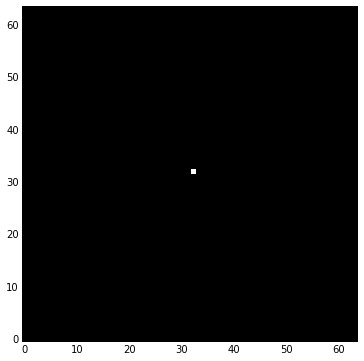

In [4]:
# 2D array representing an impulse
impulse = zeros((64,64))
impulse[32,32] = 1.0
imp(impulse)

## Box Filter and Gaussian Filter

Let's start with a box filter (or uniform filter).
You can think of this as "local averaging" of the pixels of an image.
That is, you replace each pixel with an average of the pixels around it.

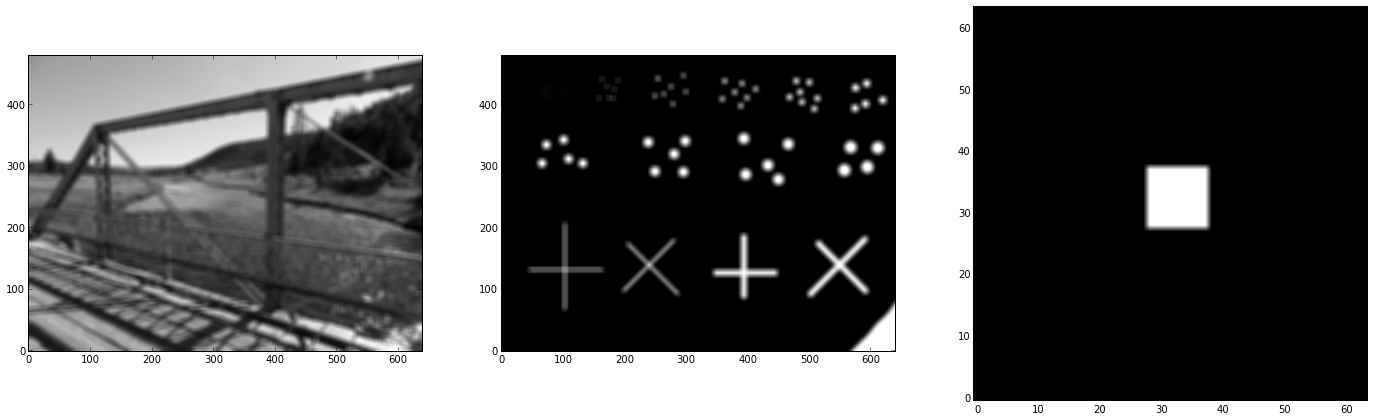

In [5]:
# filtering with a box filter, aka uniform filter
from scipy.ndimage.filters import uniform_filter as bf
imrow(bf(image,10.0),bf(test,10.0),bf(impulse,10.0))

A Gaussian filter is similar to a box filter, but instead of taking an average
over a neighborhood, you take a weighted average.
The further a pixel is away from the center pixel, the less it contributes to the average.
The weight of the averages is given by the Gaussian function (see below).
Using it has numerous mathematical and practical advantages.
This is one of the most common filters used in practice.
You can "read off" the weights in the impulse response.

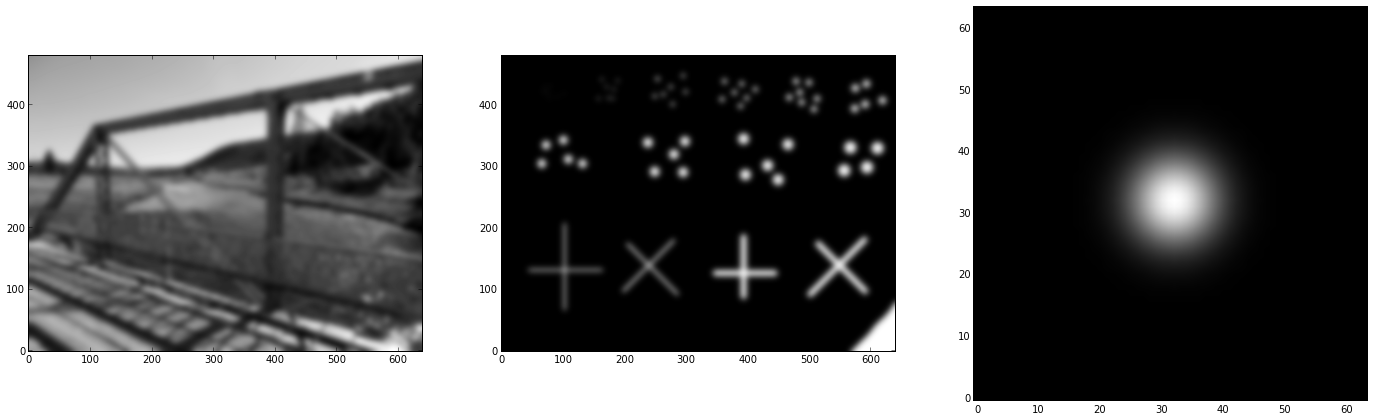

In [6]:
# gaussian filter
from scipy.ndimage.filters import gaussian_filter as gf
imrow(gf(image,5.0),gf(test,5.0),gf(impulse,5.0))

# Boundary Conditions

When computing local averages like this, you need to figure out what to do at the boundaries.
The most obvious choice would be to compute the average only over the pixels within the image,
but that turns out not to be so useful in practice.
Instead, averages are always computed over the same number of pixels, but there are different
choices for how we fill in the missing pixels.
Three common choices are 'reflect', 'wrap', and 'constant'.

These are called _boundary conditions_.

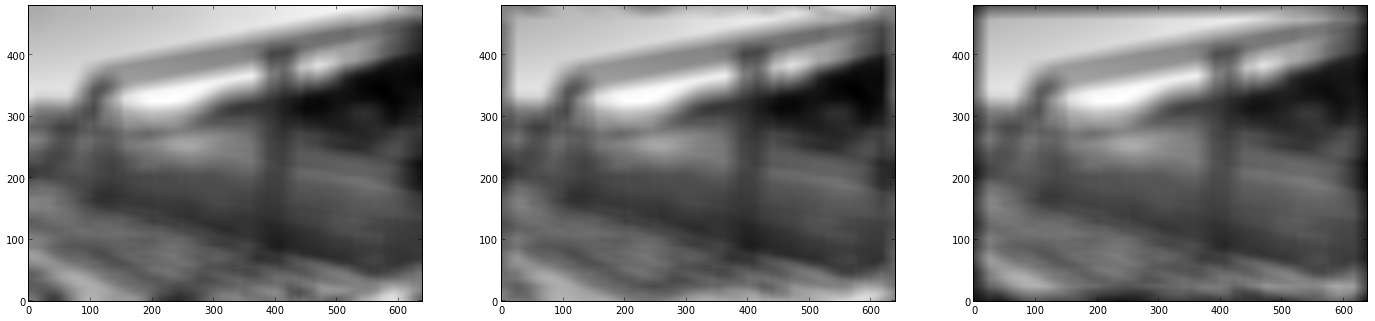

In [7]:
# reflect, wrap, constant boundary conditions
from scipy.ndimage.filters import uniform_filter as bf
imrow(bf(image,50.0,mode='reflect'),
      bf(image,50.0,mode='wrap'),
      rescale(bf(image,50.0,mode='constant',cval=0.0)))

# Noise Reduction

Why do we make our pictures blurry like this?  

Usually, it is to _reduce noise_ or _reduce image detail_.

Below is an example of a noisy image taken with a digital camera.
Next to it is the same image smoothed with a Gaussian.
As you can see, there is a lot less noise in the second image.
But in return, the image has become blurry.

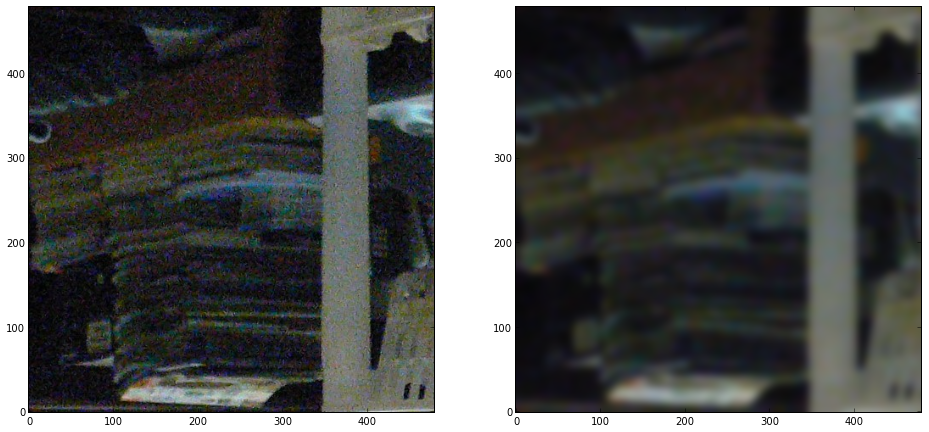

In [8]:
# noise reduction by blurring
noise = imread("imagenoise.jpg")
imrow(noise,gf(noise,(5.0,5.0,0.0)))

(Stack of Noisy Images)

It's easy to understand why smoothing reduces noise.
Assume that instead of a single image, we have a stack of noisy images.
(We actually get this kind of problem in astrophotography.)

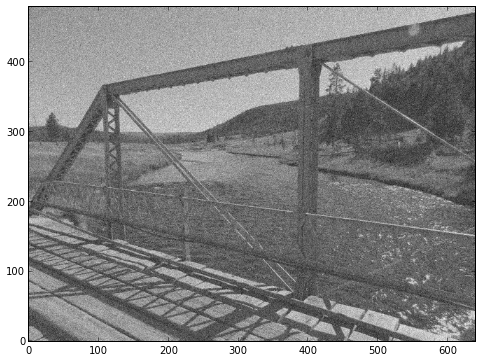

In [9]:
# stack of noisy images
noisy = array([image+0.1*randn(*image.shape) 
                  for i in range(50)])
ims(noisy[10])

That is, we are now getting multiple measurements per pixel.
Each measurement is noisy.
But the noise starts to cancel out as we average all the measurements.

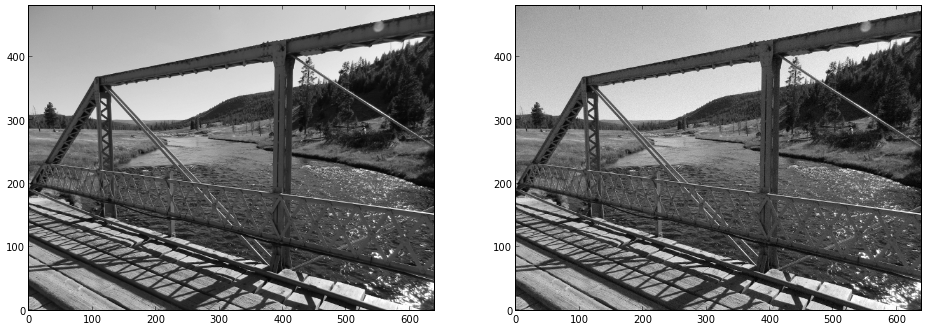

In [10]:
# noise reduction by averaging a stack of noisy images
avg = mean(noisy,axis=0)
imrow(image,clip(avg,0.0,1.0))

(averaging of images)

Mathematically, we have a signal $s$ and noise $\nu$.
Each measurement $x_i$ is the sum of the signal and the noise, $x_i = s+\nu$.
(Here, $\nu$ is a random variable.)
When we average a lot of measurements we get: 

$\bar{x} = \frac{1}{N} \sum_i^N x_i$

(averaging of images)

By linearity

$\bar{x} = \frac{1}{N} \sum_i^N x_i$

$ = \frac{1}{N} \sum_i^N (s + \nu_i) $

$ = \frac{1}{N} N s + \frac{1}{N} \sum_i^N \nu_i $

$ = s + \frac{1}{N} \sum_i^N \nu_i $

(limit)

As $N\rightarrow\infty$, we obtain:

$ E[x] = E[s] + E[\nu] = s + E[\nu] $

If the additive noise has expectation value $0$, then

$ E[x] = s $

# Linearity

(definition of linear filters)

This entire worksheet is about _linear filters_.  We haven't yet said what that means.

Linearity for a filter $F$ is defined as follows.

Given any two signals $A$ and $B$, and a real number $\alpha$, a filter is linear if
the following two identities hold:

$ F[A+B] = F[A] + F[B] $

$ F[\alpha A] = \alpha F[A]$

(Here, we write application of the filter $F$ to a signal $A$ as $F[A]$, to indicate
that the argument is a signal.  We might also write it as $F(A)$.)

8.881784197e-16


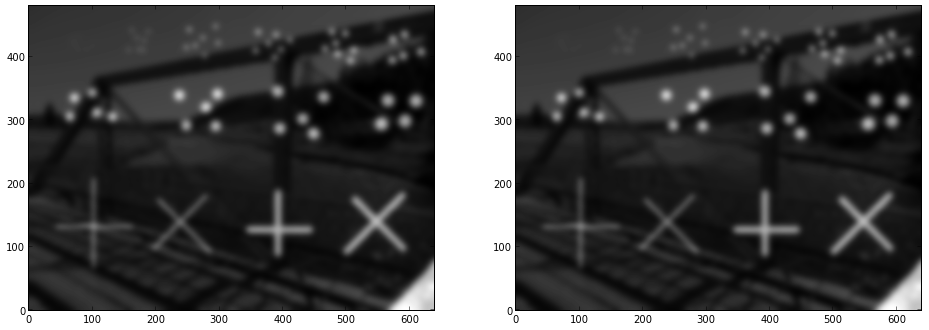

In [11]:
# demonstration of linearity
def F(image): return gf(image,5.0)
result1 = F(image)+2.0*F(test)
result2 = F(image+2.0*test)
imrow(result1/3.0,result2/3.0)
print amax(abs(result1-result2))

Linearity has important consequences, as we will see below.

# Shift Invariance

We call a filter _shift invariant_ if applying it to a shifted image is the same as shifting the result of applying the filter.

Define the _shift filter_ $S$ as:

$$ S_{(u,v)} [I]\;(x,y) = I(x+u,y+v) $$

Then a filter is shift invariant if:

$$ S[F[I]] = F[S[I]] $$

or equivalently:

$$ F[I] = S^{-1}[F[S[I]]] $$

Note that $S$ itself is both linear and shift invariant.

# Impulse Response and Convolution

Recall that the impulse response of a filter is the output of filtering an image consisting
of all zeros except a single value of 1.0 at the center.

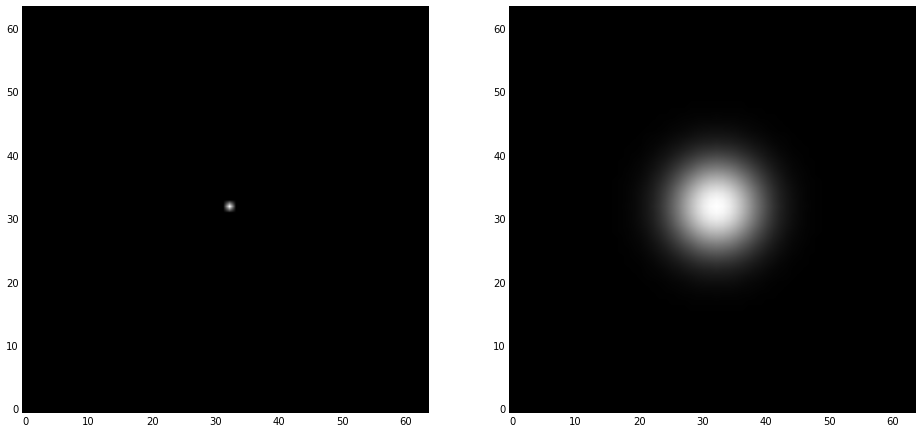

In [12]:
# impulse response of Gaussian filter
mask = gf(impulse,5.0)
imrow(impulse,mask)

The impulse response is important because it completely characterizes a linear shift invariant filter.
Why?  Because we can decompose an image into impulses, then apply the impulse response to each filter,
and then add it all up again.

(definitions)

Let the input image be $I$ and pixel $(i,j)$ given by $I_{ij}$.

Write the impulse signal as $\delta$.

Also, let $S_{ij}$ be a filter that shifts 
the image such that the pixel at the origin ends
up at position $i,j$.
It's easy to see that $S$ is also a linear filter.

Now,

$ I = \sum S_{ij}[I_{ij}\cdot\delta] $

(impulse response and filters)

$ F[I] = F[\sum S_{ij}[I_{ij}\delta]] $

By linearity:

$ = \sum F[S_{i,j} [I_{ij}\delta]] $

By shift invariance:

$ = \sum S_{i,j}[ F[I_{ij}\delta] ] $ 

By linearity, since $I_{ij}$ is just a number:

$ = \sum S_{i,j} [I_{ij} F[\delta] ] $

Here, $F[\delta]$ is the impulse response.

(equivalence)

Therefore, applying a linear filter is equivalent to 
just summing up its impulse response.

(convolution)

The operation of combining an image with the impulse response of a filter is called the _convolution_.

Ignoring boundary conditions, for infinitely large 1D signals, it is written as:

$ (x * y)~_i = \sum_{j=-\infty}^{\infty} x_j y_{i-j} $

(properties of convolutions)

Convolution has the following properties:

- commutativity: $x * y = y * x$
- associativity: $x * (y * z) = (x * y) * z$
- distributivity: $x * (y + z) = x * y + x * z$
- scalar multiplication: $\alpha (x * y) = (\alpha x) * y = x * (\alpha y)$

(2D convolution)

In 2D, convolution is defined analogously.

These properties carry over to linear shift invariant filters, since convolutions and linear
shift invariant filters are equivalent.


(cross-correlation)

Note that there is a closely related operation where the minus sign has been replaced with a plus, the _cross-correlation_:

$ (x \star y)~_i = \sum_{j=-\infty}^{\infty} x_j y_{i+j} $

The minus sign has the effect of "flipping" the mask around. 
This is also a useful operation, but the algebraic identities above don't quite hold anymore.

(convolution in the library)

Convolution is implemented by the `convolve` function.

Let us check that applying linear filter $g(\cdot,5)$ is the same as convolving with its impulse response.

That is, $g(x,5) = x * g(\delta,5)$

5.10702591328e-15


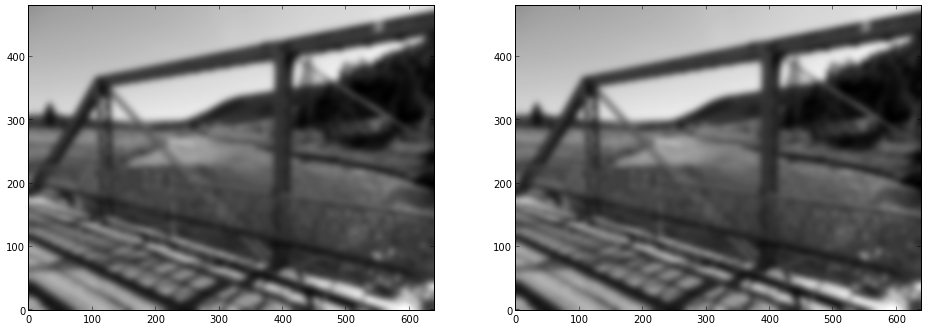

In [13]:
# convolving with the impulse response
result1 = gf(image,5.0)
mask = gf(impulse,5.0)
result2 = filters.convolve(image,mask)
imrow(result1,result2)
print amax(abs(result1-result2))

# Composition of Filters

Let us check associativity of filters.
This is a very useful property of linear filters because instead of applying a sequence
of tilers, we can pre-compose the filters and then just apply the filter once.

2.21133870582e-06


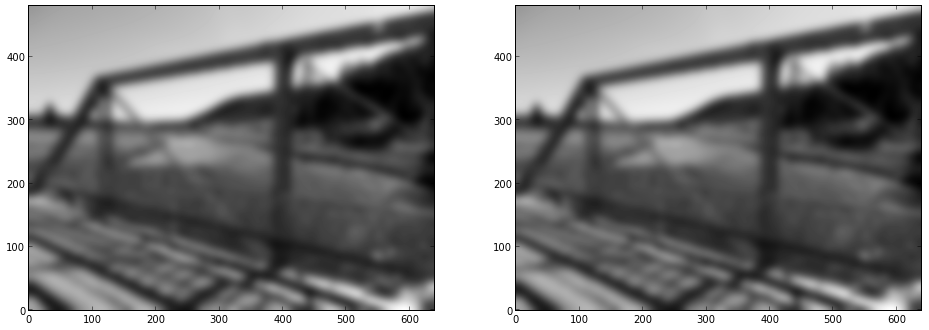

In [14]:
# composition of linear filters
result1 = filters.convolve(filters.convolve(image,mask),mask)
result2 = filters.convolve(image,filters.convolve(mask,mask))
imrow(result1,result2)
print amax(abs(result1-result2))

(composition of Gaussian filters)

Does this work for Gaussian filters?

Yes, but there is one small thing to watch out for: 
the parameter that we give to the Gaussian filter does not
quite combine in the way we expect.
Applying two Gaussian filters of width 5 is
equivalent to applying on one of width $\sqrt{5^2+5^2}$.

(Looking at the definition of the Gaussian and Gaussian filter below,
work out for yourself why these parameters behave like that.)

4.05664875084e-05


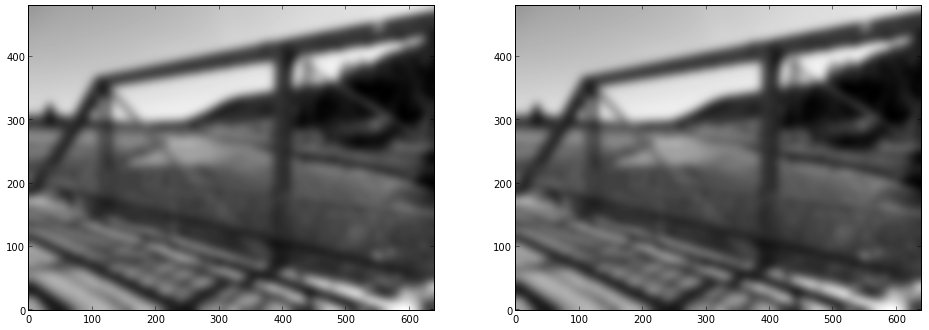

In [15]:
# composition of Gaussian filters
result1 = gf(gf(image,5.0),5.0)
result2 = gf(image,sqrt(5**2+5**2))
imrow(result1,result2)
print amax(abs(result1-result2))

# Separability

Many filtes are separable.  That is, instead of convolving with a 2D mask, we can convolve with
two 1D masks.

For Gaussian filters, we can actually specify the width and the height of the filter separately.
Applying two filters of shape (5,0) and (0,5) is equivalent to applying one filter
of shape (5,5).

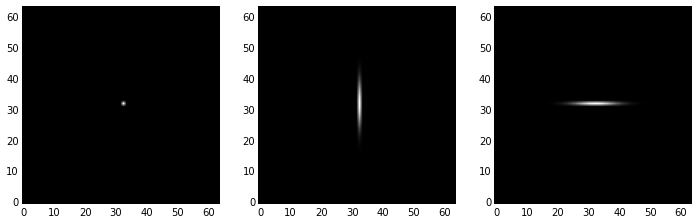

In [16]:
# horizontal and vertical Gaussians
vf = gf(impulse,(5.0,0.0))
hf = gf(impulse,(0.0,5.0))
imrow(impulse,vf,hf,s=4)

The convolution of these two filters is the same as a Gaussian.

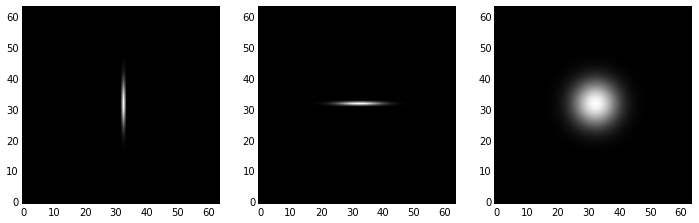

In [17]:
# convolution of horizontal and vertical Gaussians
imrow(vf,hf,filters.convolve(vf,hf),s=4)

These properties now carry over to the filters themselves. 

Note that $ g(\cdot,(5,0)) $ is implemented more efficiently than $g(\cdot,(5,5))$.

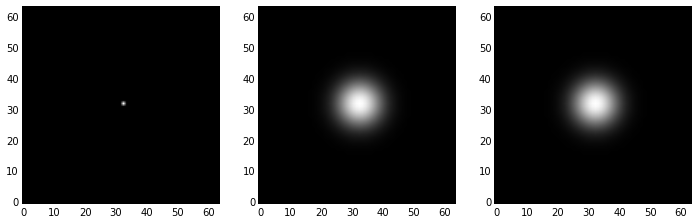

In [18]:
# separable convolution
imrow(impulse,gf(impulse,(5.0,5.0)),gf(gf(impulse,(5.0,0.0)),(0.0,5.0)),s=4)

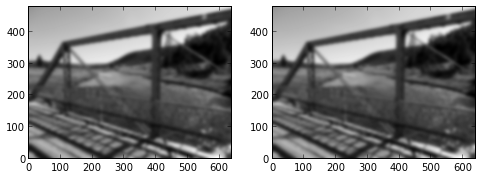

In [19]:
# separable convolution
imrow(gf(image,(5.0,5.0)),gf(gf(image,(5.0,0.0)),(0.0,5.0)),s=4)


Let's look at the timing difference.

In [20]:
# speed of separable vs full 2D convolution
import timeit
print "2D convolution",
print timeit.timeit(lambda: filters.convolve(image,mask),number=1)
print "separable convolution",
print timeit.timeit(lambda: gf(gf(image,(5.0,0.0)),(0.0,5.0)),number=100)/100.0
print "Gaussian library",
print timeit.timeit(lambda: gf(image,(5.0,5.0)),number=100)/100.0

2D convolution 1.08510494232
separable convolution 0.024929189682
Gaussian library 0.0241062402725


(speed advantage)

2D convolution is $50\times$ slower than separable convolution.

Python libraries obviously use separability for Gaussian convolution.

# Gaussians

We keep talking about Gaussian filters, but haven't really looked at what those weights are.

They are given by the following simple function.

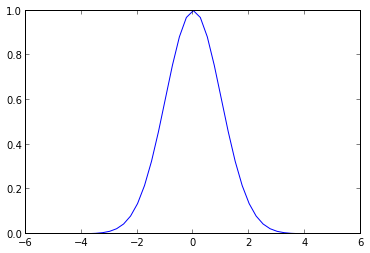

In [21]:
# Gaussians
xs = arange(-5.0,5.0,0.25)
ys = exp(-xs**2/2.0)
plot(xs,ys)


The general formula is:

$ G(x) = (2\pi\sigma^2)^{-1/2} e^\frac{-(x-\mu)^2}{2\sigma^2} $

This generalizes to multiple dimensions by just using vectors for $\mu$ and $x$.

For 2D filtering, we compute the outer product of these 1D masks. 
This is analogous to the convolution of the horizontal and vertical masks
above, where we looked at separability.

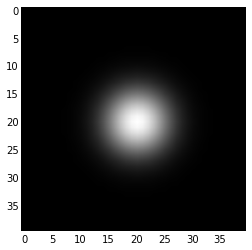

In [22]:
mask = outer(ys,ys)
mask /= sum(mask)
imshow(mask)

Now let's just look at how this filter looks.

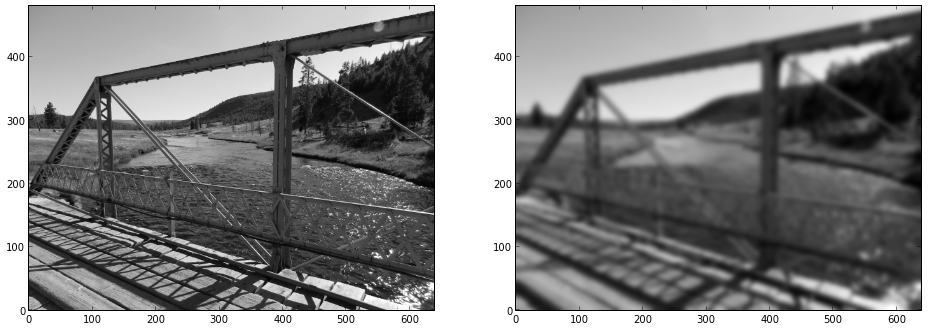

In [23]:
# convolution with an explicitly constructed Gaussian mask
imrow(image,filters.convolve(image,mask))

# Data Parallel Convolution

Above, we had already talked about linear filters as kinds of local averaging operations.

A simple implementation of this is to actually compute local averages.   Here is Python
code that does this.

In [24]:
# nested loop implementation of a box filter
def dumb_boxfilter(image,r):
    r /= 2
    w,h = image.shape
    out = zeros(image.shape)
    for i in range(r,w-r):
        for j in range(r,h-r):
            out[i,j] = mean(image[i-r:i+r,j-r:j+r].ravel())
    return out

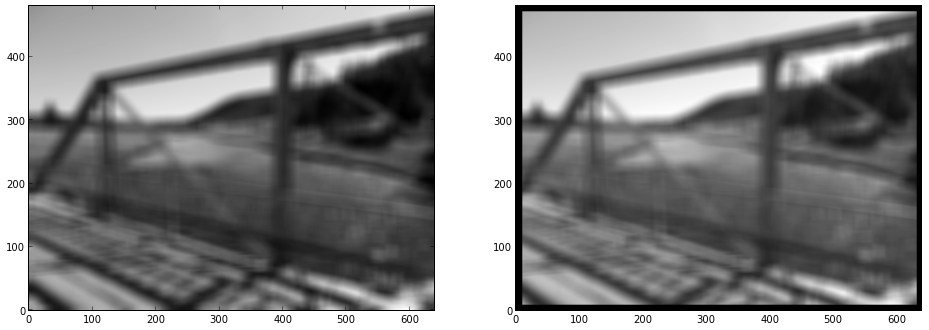

In [25]:
# library vs nested loop for box filter
imrow(filters.uniform_filter(image,20),dumb_boxfilter(image,20))

This turns out not to be a very efficient way of implementing these kinds of filters in array
languages, because there are lots of loop steps and local operations.

It is much more efficient to loop over the $r$ values and leave the addition of the big
arrays to fast array operations within Python.

In [26]:
# data parallel implementation of box filter
def myaverage(image,r):
    out = zeros(image.shape)
    for i in range(-r/2,r/2):
        for j in range(-r/2,r/2):
            out += roll(roll(image,i,axis=0),j,axis=1)
    return out*1.0/(r*r)

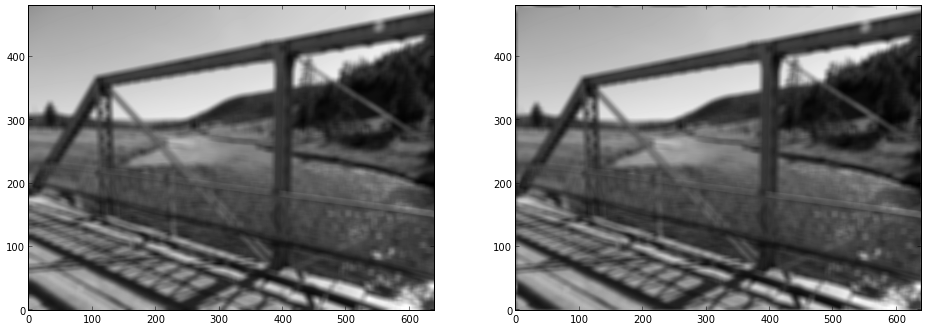

In [27]:
imrow(filters.uniform_filter(image,10),myaverage(image,10))

We can also implement general convolutions with masks by computing a weighted average/sum.

(Think about: which boundary conditions does this implement?)

In [28]:
# data parallel implementation of convolution
def myconvolve(image,mask):
    mw,mh = mask.shape
    out = zeros(image.shape)
    for i in range(mw):
        for j in range(mh):
            out += mask[i,j]*roll(roll(image,mw/2-i,axis=0),mh/2-j,axis=1)
    return out

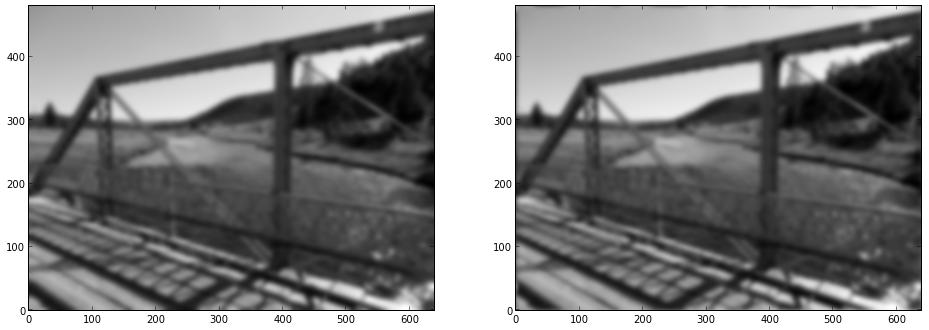

In [30]:
# library vs data parallel convolution
imrow(filters.convolve(image,mask),myconvolve(image,mask))



(note the differences in boundary conditions)